# Assignment - 7- B
## Image similarity estimation using a Siamese Network with a triplet loss

## Introduction

A [Siamese Network](https://en.wikipedia.org/wiki/Siamese_neural_network) is a type of network architecture that
contains two or more identical subnetworks used to generate feature vectors for each input and compare them.

Siamese Networks can be applied to different use cases, like detecting duplicates, finding anomalies, and face recognition.

This example uses a Siamese Network with three identical subnetworks. We will provide three images to the model, where
two of them will be similar (_anchor_ and _positive_ samples), and the third will be unrelated (a _negative_ example.)
Our goal is for the model to learn to estimate the similarity between images.

For the network to learn, we use a triplet loss function. You can find an introduction to triplet loss in the
[FaceNet paper](https://arxiv.org/pdf/1503.03832.pdf) by Schroff et al,. 2015. In this example, we define the triplet
loss function as follows:

`L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)`

## Tasks
1. Fetch the data using the following code and create tripets using the helper code. Visualize few random triplets
2. Write a code to preprocess the images. Standard preprocessing includes decoding the image, convert the dtype to float and resizing the image. Use tensorflow functions to do so and store your data in tensorflow variables rather than numpy or python lists as it is much faster.
3. Shuffle the dataset, Split into train and validation. (80-20)
4. Use a pretrained ResNet50 to obtain embeddings for images (freeze the weights). Add few Dense and Batch Norm layers at the end.  Implement triplet loss and train the model. Keep a track of val loss.
5. Now unfreeze last few layers of ResNet50 and rerun the experiment. Compare the val loss of this model with val loss of previous model(with parameters freezed).
6. Use cosine cosine similarity metric to measure how to 2 output embeddings are similar to each other. Is similiarty of  (Anchor , Positive ) > (Anchor , Negative)


## Note -

Change the runtime type to T4 GPU on your colab. Without GPU, the model takes much longer.

## Dataset
* Original Dataset - https://vis-www.cs.umass.edu/lfw/
* Fewer examples from this dataset suitable for our task is selected and is hosted in the following link.

In [1]:
!gdown 1ykjp7xHOE2TSTjcDzm6NlJRP2n_JSaBW

Downloading...
From: https://drive.google.com/uc?id=1ykjp7xHOE2TSTjcDzm6NlJRP2n_JSaBW
To: /content/LFW_Trimmed_zip.zip
100% 9.45M/9.45M [00:00<00:00, 97.5MB/s]


In [2]:
!unzip /content/LFW_Trimmed_zip.zip

Archive:  /content/LFW_Trimmed_zip.zip
replace LFW_Trimmed/Cameron_Diaz/Cameron_Diaz_0003.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: LFW_Trimmed/Cameron_Diaz/Cameron_Diaz_0003.jpg  
  inflating: LFW_Trimmed/Art_Howe/Art_Howe_0001.jpg  
  inflating: LFW_Trimmed/Bernard_Law/Bernard_Law_0002.jpg  
  inflating: LFW_Trimmed/Bernard_Law/Bernard_Law_0003.jpg  
  inflating: LFW_Trimmed/Art_Howe/Art_Howe_0004.jpg  
  inflating: LFW_Trimmed/Cameron_Diaz/Cameron_Diaz_0002.jpg  
  inflating: LFW_Trimmed/Aaron_Peirsol/Aaron_Peirsol_0004.jpg  
  inflating: LFW_Trimmed/Alan_Greenspan/Alan_Greenspan_0002.jpg  
  inflating: LFW_Trimmed/Charlton_Heston/Charlton_Heston_0004.jpg  
  inflating: LFW_Trimmed/Calista_Flockhart/Calista_Flockhart_0001.jpg  
  inflating: LFW_Trimmed/Bernard_Law/Bernard_Law_0005.jpg  
  inflating: LFW_Trimmed/Cameron_Diaz/Cameron_Diaz_0006.jpg  
  inflating: LFW_Trimmed/Charlton_Heston/Charlton_Heston_0006.jpg  
  inflating: LFW_Trimmed/Art_Howe/Art_Howe_0003.jpg  

In [3]:
image_dir = "/content/LFW_Trimmed"

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from pathlib import Path
import pandas as pd

(250, 250, 3, 3)


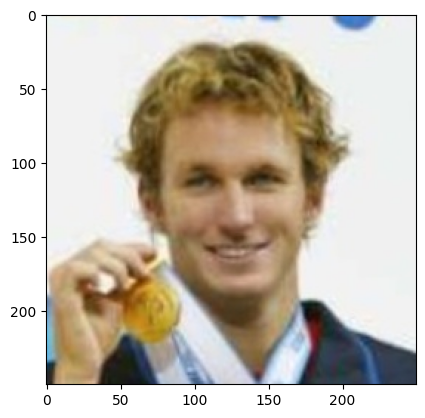

In [5]:
filename = image_dir+"/Aaron_Peirsol/Aaron_Peirsol_0001.jpg"
pixels = plt.imread(filename)

# Show RGB shape
rgb_pixels = np.stack((pixels, pixels, pixels), axis=2)
print(rgb_pixels.shape)

# Show example image
plt.imshow(pixels)
plt.show()

(250, 250, 3, 3)


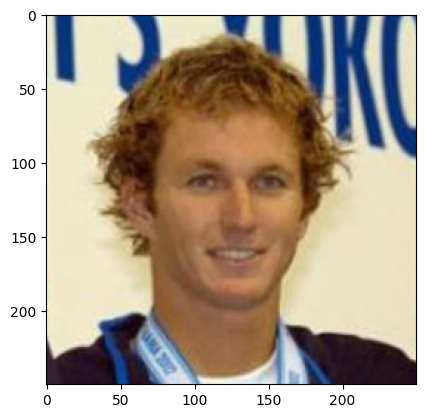

In [6]:
filename = image_dir+"/Aaron_Peirsol/Aaron_Peirsol_0002.jpg"
pixels = plt.imread(filename)

# Show RGB shape
rgb_pixels = np.stack((pixels, pixels, pixels), axis=2)
print(rgb_pixels.shape)

# Show example image
plt.imshow(pixels)
plt.show()

In [7]:
target_shape = (250,250)

In [8]:

subjects= os.listdir(image_dir)   # list of all people
image_paths = []
for subject in subjects:
    subject_path = os.path.join(image_dir, subject)
    for filename in os.listdir(subject_path):
        full_path = os.path.join(subject_path, filename)
        image_paths.append(full_path)    # storing path for each and every image in image paths


#photos_list_flatten = [item for sublist in photos_list for item in sublist]
print(len(subjects))
print(subjects[:5])
print(image_paths[:2])

100
['Mark_Hurlbert', 'Roy_Moore', 'Roger_Moore', 'Cameron_Diaz', 'Emanuel_Ginobili']
['/content/LFW_Trimmed/Mark_Hurlbert/Mark_Hurlbert_0005.jpg', '/content/LFW_Trimmed/Mark_Hurlbert/Mark_Hurlbert_0002.jpg']


In [9]:
cache_dir = Path("/content/.keras")

In [10]:
# Define anchor and positive images paths
anchor_images_path = cache_dir / "left" / "anchors"
positive_images_path = cache_dir / "right" / "positives"

In [11]:
# Create cache directories
anchor_images_path.mkdir(parents=True, exist_ok=True)
positive_images_path.mkdir(parents=True, exist_ok=True)


In [12]:
from itertools import combinations  # imported to create combinations
import shutil


In [13]:
def create_triplets(subjects, photos_list, anchor_images_path, positive_images_path):
    anchor_positive = []
    negative = []

    for subject in subjects:
        subject_photos = [i for i in photos_list if subject in i]
        non_subject_photos = [i for i in photos_list if subject not in i]

        anchor_positiveset = list(combinations(subject_photos, 2))
        anchor_positive.extend(anchor_positiveset)
        negative.extend(random.choices(non_subject_photos, k=len(anchor_positiveset)))

        # Copy images to the anchor and positive directories
        for anchor, positive in anchor_positiveset:
            shutil.copy(anchor, anchor_images_path)
            shutil.copy(positive, positive_images_path)

    data_df = pd.DataFrame(anchor_positive, columns=['anchor', 'positive'])
    data_df['negative'] = negative
    return data_df


In [14]:
data_df = create_triplets(subjects, image_paths, anchor_images_path, positive_images_path)
print(data_df.shape)

(1003, 3)


In [15]:
import tensorflow as tf
from pathlib import Path
from keras import applications
from keras import layers
from keras import losses
from keras import ops
from keras import optimizers
from keras import metrics
from keras import Model
from keras.applications import resnet



In [16]:
def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image

In [17]:
def preprocess_triplets(anchor, positive, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

In [18]:
anchor_images = sorted(
    [str(anchor_images_path / f) for f in os.listdir(anchor_images_path)]
)

positive_images = sorted(
    [str(positive_images_path / f) for f in os.listdir(positive_images_path)]
)

image_count = len(anchor_images)


In [19]:
anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)


In [20]:
rng = np.random.RandomState(seed=42)
rng.shuffle(anchor_images)
rng.shuffle(positive_images)


In [21]:
negative_images = anchor_images + positive_images
np.random.RandomState(seed=32).shuffle(negative_images)


In [22]:
negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
negative_dataset = negative_dataset.shuffle(buffer_size=4096)


In [23]:
dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)


In [24]:
train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))


In [25]:
train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

In [26]:
val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

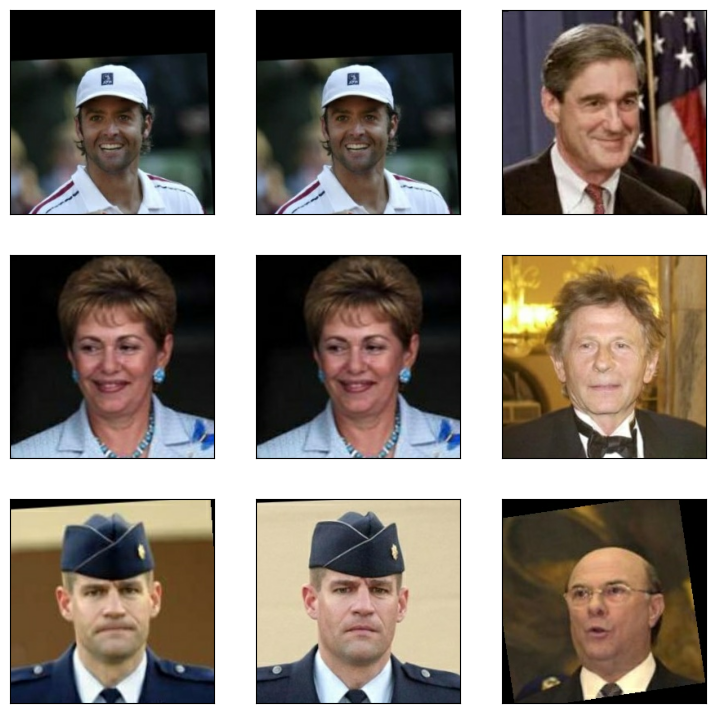

In [27]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

In [28]:
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [29]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = ops.sum(tf.square(anchor - positive), -1)
        an_distance = ops.sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [30]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

In [32]:
siamese_model = SiameseModel(siamese_network)


In [34]:
siamese_model.save_weights('siamese_model_checkpoint.weights.h5')


In [35]:
siamese_model.compile(optimizer=optimizers.Adam(0.0001))


In [36]:
siamese_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 98s 5s/step - loss: 0.3638 - val_loss: 0.3687
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 497ms/step - loss: 0.2201 - val_loss: 0.1162
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 637ms/step - loss: 0.2294 - val_loss: 0.1500
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 495ms/step - loss: 0.1286 - val_loss: 0.0774
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 496ms/step - loss: 0.1250 - val_loss: 0.1109
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 562ms/step - loss: 0.1228 - val_loss: 0.0724
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 497ms/step - loss: 0.0596 - val_loss: 0.0675
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 517ms/step - loss: 0.0398 - val_loss: 0.0449
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 551ms/step - loss: 0.0645 - val_loss: 0.0497
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 496ms/step - loss: 0.0631 - val_loss: 0.0472


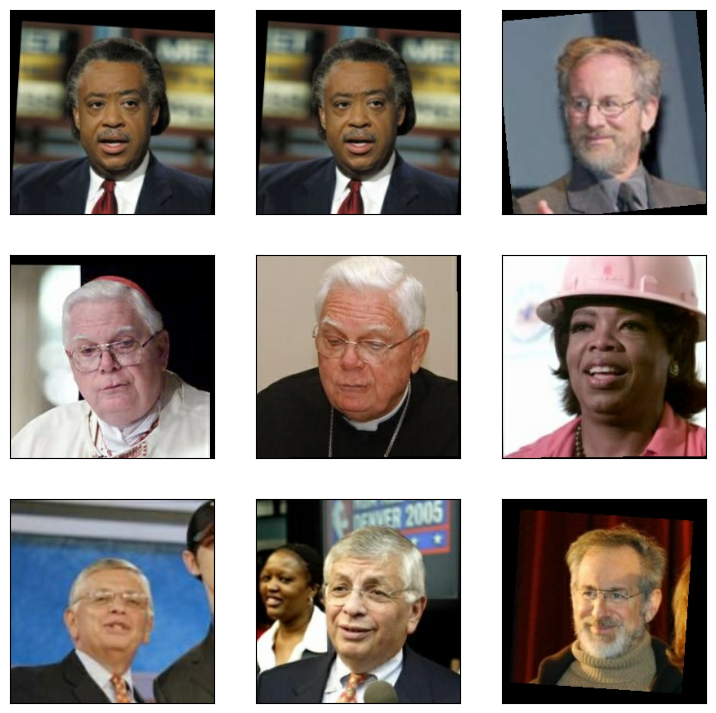

In [37]:
sample = next(iter(train_dataset))
visualize(*sample)

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor)),
    embedding(resnet.preprocess_input(positive)),
    embedding(resnet.preprocess_input(negative)),
)

In [38]:
cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())

Positive similarity: 0.9996215
Negative similarity 0.9992655


In [39]:
## UNFREEEZING THE LAYERS

In [40]:
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

trainable_from_layer = "conv5_block1_out"
for layer in base_cnn.layers:
    layer.trainable = True
    if layer.name == trainable_from_layer:
        break


In [ ]:
siamese_model.compile(optimizer=optimizers.Adam(0.0001))

In [47]:
siamese_model.fit(train_dataset, epochs=10, validation_data=val_dataset)


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 484ms/step - loss: 0.0413 - val_loss: 0.0472
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 505ms/step - loss: 0.0355 - val_loss: 0.1430
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 492ms/step - loss: 0.0490 - val_loss: 0.0434
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 640ms/step - loss: 0.0243 - val_loss: 0.0253
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 495ms/step - loss: 0.0297 - val_loss: 0.0084
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 549ms/step - loss: 0.0201 - val_loss: 0.0052
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 490ms/step - loss: 0.0311 - val_loss: 0.0337
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 494ms/step - loss: 0.0349 - val_loss: 0.0253
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 561ms/step - loss: 0.0229 - val_loss: 0.0189
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 640ms/step - loss: 0.0149 - val_loss: 0.0373


In [43]:
siamese_model.save_weights('siamese_model_checkpoint.weights.h5')


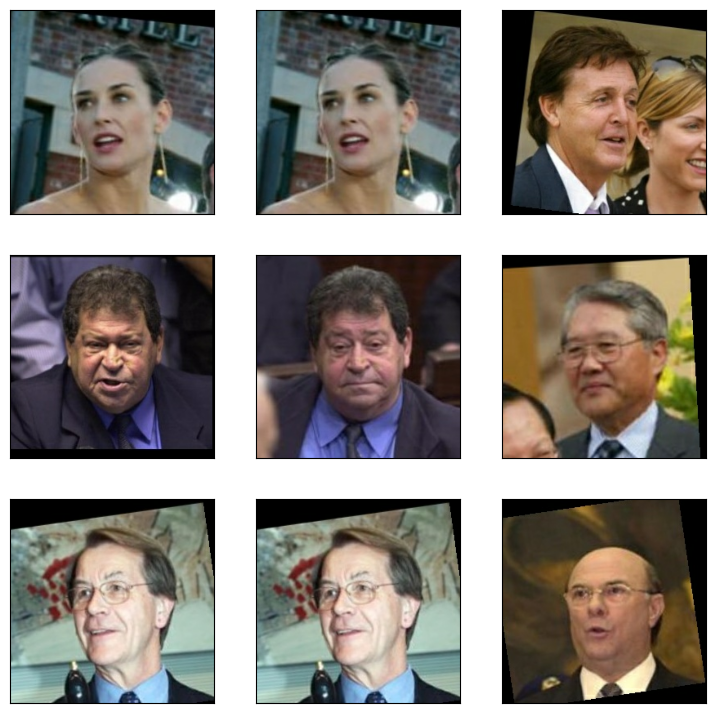

In [44]:
sample = next(iter(train_dataset))
visualize(*sample)

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor)),
    embedding(resnet.preprocess_input(positive)),
    embedding(resnet.preprocess_input(negative)),
)

In [46]:
cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())

Positive similarity: 0.9944049
Negative similarity 0.9904726


**Comparison**

*First training with some layers freezed*

Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 496ms/step - loss: 0.0631 - val_loss: 0.0472

*Second training with layers unfreezed*

Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 640ms/step - loss: 0.0149 - val_loss: 0.0373

The loss and val_loss both reduced in the second training

**Yes, similiarty of (Anchor , Positive ) > (Anchor , Negative)**